In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import haversine as hs
import geopandas as gp
from shapely.geometry import MultiPoint, Point, Polygon
import numpy as np

from pyomo.environ import Var, Expression, NonNegativeReals, Block, ConcreteModel, Constraint, Objective, Param, maximize, SolverFactory,RangeSet
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from pyomo.environ import Block, Expression, units as pyunits
import math
from watertap3.utils.watertap_df import watertap_setup,run_watertap3, run_and_return_model,print_results
# from watertap3.utils import watertap_setup,run_watertap3, run_and_return_model
from watertap3.utils import get_case_study

from sklearn.cluster import DBSCAN
from shapely import wkt

from watertap3.truck_pipe_cost_functions import pipe_costing,elevation_gain, elevation
from pyomo.util.infeasible import log_infeasible_constraints, log_infeasible_bounds

from IPython.display import clear_output

Find centroids of brackish water sites within 25 miles

Location of brackish water sites that satisfy conditions for selection of brackish wells

In [2]:
bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs_transport_updated_basis.csv')

In [3]:
contiguous_usa = ('AL','AZ','AR','CA','CO','CT','DE','FL','GA','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE',
                  'NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY','DC')

Create coordinates dataframa for all brackish wells

In [4]:
coords = bw_df[['Latitude', 'Longitude','state_alpha']]

Function to find the centroid

In [5]:
def find_centroid(coords,cluster_range = 25):
    kms_per_radian = 6371.0088
    range_km = cluster_range*1.609343502101154
    epsilon = range_km/ kms_per_radian

    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_

    # get the number of clusters
    num_clusters = len(set(cluster_labels))

    # turn the clusters in to a pandas series, where each element is a cluster of points
    clusters = pd.Series((coords[cluster_labels==n] for n in range(num_clusters)))
    centroids = []

    for ea in clusters:
        centroids.append((MultiPoint(ea).centroid.x, MultiPoint(ea).centroid.y))

    centroids = np.array(centroids)
    return [centroids,cluster_labels]

Go through each state and find centroid of brackish sites groups

In [6]:
bw_df_centroid = pd.DataFrame(columns= bw_df.columns)
cluster_df = pd.DataFrame(columns = ['cluster_labels','centroid'])

for state in bw_df['state_alpha'].unique():
    # print(state)

    coords_input = coords[coords['state_alpha']==state][['Latitude', 'Longitude']].to_numpy()
    centroids,cluster_labels = find_centroid(coords_input,10)

    loc = [Point(xy) for xy in zip(centroids[:,1],centroids[:,0])]
    loc = gp.GeoDataFrame(geometry = loc, crs='EPSG:4326')
    loc.geometry = loc.geometry.to_crs('EPSG:4326')

    # Assign cluster label
    temp = pd.DataFrame(columns = ['cluster_labels','centroid'])
    temp['cluster_labels'] = cluster_labels
    temp['centroid'] = loc.geometry[cluster_labels].values

    cluster_df= pd.concat([cluster_df,temp])
    cluster_df.reset_index()

    bw_df_centroid = pd.concat([bw_df_centroid,bw_df[bw_df['state_alpha']==state]])
    
bw_df_centroid = bw_df_centroid.assign(centroid = cluster_df['centroid'].values)
bw_df_centroid['cluster_id'] = pd.factorize(bw_df_centroid['centroid'])[0]


<AxesSubplot: >

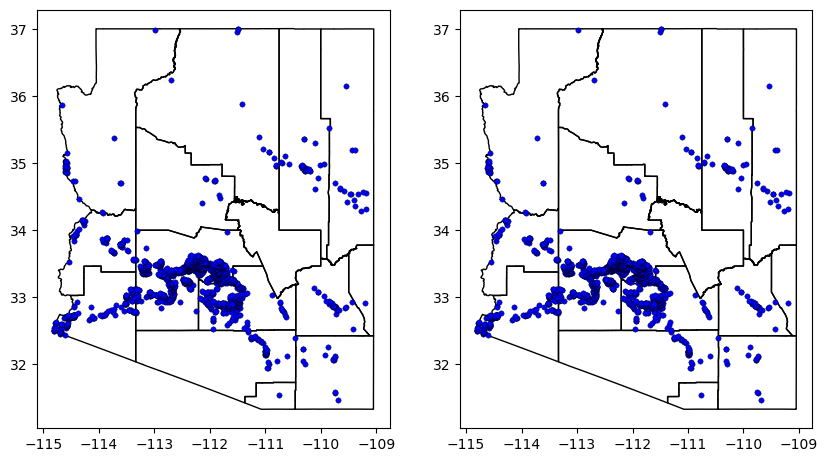

In [8]:
us_counties = gp.read_file(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\GeoData\US_County_Boundaries\US_CountyBndrys.shp')
us_counties = us_counties.to_crs("EPSG:4326")

state_code = '04'
state = us_counties.loc[us_counties['STATEFP']==state_code]
state_alpha = 'AZ'

bw_long = bw_df_centroid[bw_df_centroid['state_alpha']==state_alpha]['Longitude']
bw_lat = bw_df_centroid[bw_df_centroid['state_alpha']==state_alpha]['Latitude']

bw_geometry = [Point(xy) for xy in zip(bw_long,bw_lat)]
bw_geo_df = gp.GeoDataFrame(geometry = bw_geometry, crs='EPSG:4326')
bw_geo_df.geometry = bw_geo_df.geometry.to_crs('EPSG:4326')

fig, (ax,ax0) = plt.subplots(1,2,figsize = (10,10))

state.plot(ax=ax,figsize=(50, 50),facecolor ='none',edgecolor ='black')
bw_geo_df.plot(ax=ax, color='blue',edgecolors='black' ,linewidth = 0.25, markersize = 15,label = "BW Sites")

state.plot(ax=ax0,figsize=(50, 50),facecolor ='none',edgecolor ='black')
# bw_geo_df.plot(ax=ax0, markersize = 15, edgecolors = 'black', c='blue',linewidth = 0.25, label = "BW Sites")

for cluster in bw_df_centroid[bw_df_centroid['state_alpha']==state_alpha]['cluster_id'].unique():
    temp = bw_df_centroid[bw_df_centroid['state_alpha']==state_alpha][bw_df_centroid['cluster_id']==cluster]
    ax0.scatter(temp['Longitude'], temp['Latitude'],s = 10)


In [60]:
# Calculating the distance to the centroid for a state

bw_df_centroid = bw_df_centroid[bw_df_centroid['state_alpha']==state_alpha]

dist= []
centroid_elev = []
well_elev = []

for i in bw_df_centroid.index:
    clear_output(wait=True)
    print(i, i/len(bw_df_centroid.index))
    bw_long = bw_df_centroid.loc[i]['Longitude']
    bw_lat = bw_df_centroid.loc[i]['Latitude']

    bw_loc = (bw_lat,bw_long)

    cent_long = bw_df_centroid.loc[i].centroid.x
    cent_lat = bw_df_centroid.loc[i].centroid.y

    cent_loc = (cent_lat,cent_long)

    dist_km = hs.haversine(cent_loc,bw_loc)

    dist.append(dist_km)
    centroid_elev.append(elevation(cent_lat,cent_long))
    well_elev.append(elevation(bw_lat,bw_long))

bw_df_centroid['dist_miles'] = dist
bw_df_centroid['centroid_elev'] = centroid_elev
bw_df_centroid['well_elev'] = well_elev

# bw_df_centroid[bw_df_centroid['state_alpha']=='AZ']

1065 5.406091370558376


In [145]:
bw_df_centroid.head()

,unique_site_ID,state_alpha,county_nm,Latitude,Longitude,well_depth_ft,well_yield,TDS_kgm3,state,elec_price,...,recovery,capital,onm,elec_int,tds_out,centroid,cluster_id,dist_miles,centroid_elev,well_elev
21,FETH-261730N0974730.1,TX,Cameron,26.291667,-97.791694,697.0,0.056956,4.06,Texas,0.0545,...,89.064718,14.228282,0.561861,3.400540,0.124022,POINT (-97.78676 26.27049),85,2.405851,12.923176,12.889527
22,FETH-262920N0974650.1,TX,Willacy,26.488889,-97.780583,1054.0,0.063528,2.32,Texas,0.0545,...,90.642666,15.015387,0.628462,3.487275,0.092029,POINT (-97.78058 26.48889),86,0.000000,9.465533,9.465533
24,FETH-291610N1003320.1,TX,Kinney,29.269444,-100.555583,1408.0,0.043813,2.61,Texas,0.0545,...,90.598937,11.540862,0.483226,3.978312,0.102851,POINT (-100.55558 29.26944),87,0.000000,323.440002,323.440002
25,FETH-292140N0950400.1,TX,Galveston,29.361111,-95.066694,884.0,0.113475,1.66,Texas,0.0545,...,91.107114,23.081943,1.008422,3.120036,0.072283,POINT (-95.09363 29.45418),88,10.672506,4.711225,5.902136
28,FETH-311340N0970030.1,TX,Falls,31.227778,-97.008361,2709.0,0.050385,1.68,Texas,0.0545,...,91.618259,12.529342,0.647890,5.228735,0.082720,POINT (-97.00836 31.22778),89,0.000000,150.522293,150.522293


In [162]:
bw_df_centroid_1 = bw_df_centroid.sort_values(['well_yield'],ascending = False, ignore_index=True).sort_values(['dist_miles'],ignore_index=True).groupby('cluster_id')
bw_df_centroid_1 = bw_df_centroid_1.apply(pd.DataFrame)

# bw_df_centroid_1 = bw_df_centroid_1.sort_values(['dist_miles'],ignore_index=True).groupby('cluster_id')
# bw_df_centroid_1 = bw_df_centroid_1.apply(pd.DataFrame)

In [163]:
bw_df_centroid_1.head()

,unique_site_ID,state_alpha,county_nm,Latitude,Longitude,well_depth_ft,well_yield,TDS_kgm3,state,elec_price,...,recovery,capital,onm,elec_int,tds_out,centroid,cluster_id,dist_miles,centroid_elev,well_elev
0,NURE-OR8579,TX,Jackson,29.148000,-96.600000,984.0,0.479486,0.582225,Texas,0.0545,...,92.506184,74.614505,3.817247,2.908792,0.036665,POINT (-96.60000 29.14800),135,0.0,30.544550,30.544550
1,TXWDB_BRAC-3283,TX,Reeves,31.344999,-103.293055,180.0,0.018927,0.543000,Texas,0.0545,...,93.467691,6.375004,0.173715,2.104813,0.050954,POINT (-103.29305 31.34500),144,0.0,805.944336,805.944336
2,NURE-OR16172,TX,Hardeman,34.324000,-99.850000,121.0,0.056781,3.544357,Texas,0.0545,...,89.423249,14.096720,0.493745,2.644480,0.114065,POINT (-99.85000 34.32400),111,0.0,466.660004,466.660004
3,NURE-OR6919,TX,Bandera,29.667000,-99.164000,1020.0,0.018927,0.554670,Texas,0.0545,...,93.473109,6.377205,0.202064,3.034978,0.052220,POINT (-99.16400 29.66700),132,0.0,471.229980,471.229980
4,USGS-295957095152601,TX,Harris,29.999386,-95.257431,860.0,0.018927,1.457087,Texas,0.0545,...,92.211799,6.515018,0.206689,3.155499,0.084624,POINT (-95.25743 29.99939),157,0.0,25.163609,25.163609


Function to create treatment train CSV s

In [164]:
cols = ['state','state_elec_price','cluster_id','cluster_loc','centroid_elev','well_count','well_id','well_elev','latitude','longitude','well_depth','well_yield','tds','dist','avg_well_yield','avg_tds']
bw_cluster_lcow = pd.DataFrame(columns=cols)

bw_df_centroid_sample = bw_df_centroid_1[bw_df_centroid_1['state_alpha']==state_alpha]

# Iterate through each cluster id
for cl_id in bw_df_centroid_sample.cluster_id.unique():
        bw_cluster = bw_df_centroid_sample[bw_df_centroid_sample['cluster_id']==cl_id]
        # TDS 
        avg_tds = 0
        # well yield
        avg_well_yield  = 0
        well_list = []
        lat_list = []
        long_list = []
        well_depth_list = []
        well_yield_list = []
        tds_list = []
        dist_list = []

        centroid_elev_list = []
        well_elev_list = []

        well_count = 0
        # Iterate over each brackish water site within a cluster
        for well_id in bw_cluster['unique_site_ID'].unique():

                well_count = well_count + 1
                bw_cluster_well =bw_cluster[bw_cluster['unique_site_ID']==well_id]
                # Calculate average well yield
                avg_well_yield_old = avg_well_yield
                avg_well_yield = avg_well_yield + bw_cluster[bw_cluster['unique_site_ID']==well_id]['well_yield'].values[0]

                # Calculate average TDS
                avg_tds = (avg_tds*avg_well_yield_old + bw_cluster[bw_cluster['unique_site_ID']==well_id]['TDS_kgm3'].values[0] * bw_cluster[bw_cluster['unique_site_ID']==well_id]['well_yield'].values[0])/avg_well_yield
                
                well_list.append(well_id)
                lat_list.append(bw_cluster_well['Latitude'].values)
                long_list.append(bw_cluster_well['Longitude'].values)
                well_depth_list.append(bw_cluster_well['well_depth_ft'].values)
                well_yield_list.append(bw_cluster_well['well_yield'].values)
                tds_list.append(bw_cluster_well['TDS_kgm3'].values)
                dist_list.append(bw_cluster_well['dist_miles'].values)
                centroid_elev_list.append(bw_cluster_well['centroid_elev'])
                well_elev_list.append(bw_cluster_well['well_elev'])

                
                # Update results table
                temp = {'state': state_alpha,
                        'state_elec_price': bw_df_centroid_sample['elec_price'].unique()[0],
                        'cluster_id': cl_id,
                        'cluster_loc':bw_cluster['centroid'].unique()[0],
                        'centroid_elev': list(centroid_elev_list),
                        'well_count': well_count,
                        'well_id': list(well_list),
                        'well_elev': list(well_elev_list),
                        'latitude': list(lat_list),
                        'longitude': list(long_list),
                        'well_depth': list(well_depth_list),
                        'well_yield':list(well_yield_list),
                        'tds': list(tds_list),
                        'dist':list(dist_list),
                        'avg_well_yield': avg_well_yield,
                        'avg_tds':avg_tds
                        }
                
                temp = pd.DataFrame([temp])
                bw_cluster_lcow = pd.concat([bw_cluster_lcow,temp],ignore_index=True)
                # bw_cluster_lcow.reset_index()

bw_cluster_lcow

,state,state_elec_price,cluster_id,cluster_loc,centroid_elev,well_count,well_id,well_elev,latitude,longitude,well_depth,well_yield,tds,dist,avg_well_yield,avg_tds
0,TX,0.0545,135,POINT (-96.59999999999999 29.148),[[30.544549942]],1,[NURE-OR8579],[[30.544549942]],[[29.148]],[[-96.6]],[[984.0]],[[0.4794855199999999]],[[0.5822249]],[[0.0]],0.479486,0.582225
1,TX,0.0545,144,POINT (-103.293055 31.344999),[[805.944335938]],1,[TXWDB_BRAC-3283],[[805.944335938]],[[31.344999]],[[-103.293055]],[[180.0]],[[0.01892706]],[[0.543]],[[0.0]],0.018927,0.543000
2,TX,0.0545,111,POINT (-99.84999999999999 34.324),[[466.660003662]],1,[NURE-OR16172],[[466.660003662]],[[34.324]],[[-99.85]],[[121.0]],[[0.0567811799999999]],[[3.5443573]],[[0.0]],0.056781,3.544357
3,TX,0.0545,132,POINT (-99.164 29.667),[[471.229980469]],1,[NURE-OR6919],[[471.229980469]],[[29.667]],[[-99.164]],[[1020.0]],[[0.01892706]],[[0.5546702]],[[0.0]],0.018927,0.554670
4,TX,0.0545,157,POINT (-95.257431 29.9993858),[[25.163608551]],1,[USGS-295957095152601],[[25.163608551]],[[29.9993858]],[[-95.257431]],[[860.0]],[[0.01892706]],[[1.4570872]],[[0.0]],0.018927,1.457087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,TX,0.0545,112,POINT (-97.291 30.158),"[[136.479995728], [136.479995728]]",2,"[NURE-OR17189, NURE-OR17194]","[[153.195999146], [158.382003784]]","[[30.215], [30.101]]","[[-97.298], [-97.284]]","[[535.0], [515.0]]","[[0.095897104], [0.017980707]]","[[1.1333193], [0.5960022]]","[[6.373730328175834], [6.3737714052115075]]",0.113878,1.048480
193,TX,0.0545,98,POINT (-98.1035 29.477),[[175.402572632]],1,[NURE-OR10580],[[190.974182129]],[[29.522]],[[-98.152]],[[20.0]],[[0.01577255]],[[1.353757]],[[6.860737843230948]],0.015773,1.353757
194,TX,0.0545,98,POINT (-98.1035 29.477),"[[175.402572632], [175.402572632]]",2,"[NURE-OR10580, NURE-OR33717]","[[190.974182129], [152.777709961]]","[[29.522], [29.432]]","[[-98.152], [-98.055]]","[[20.0], [298.0]]","[[0.01577255], [0.0126180399999999]]","[[1.353757], [3.8061271]]","[[6.860737843230948], [6.862163957947368]]",0.028391,2.443699
195,TX,0.0545,159,POINT (-93.9160042 30.07118415),[[4.633780956]],1,[USGS-300431093503801],[[2.542119265]],[[30.075489]],[[-93.8440552]],[[686.0]],[[0.0469391088]],[[0.5994465999999999]],[[6.9399299224346205]],0.046939,0.599447


Preliminary steps to calculate treatment portion of LCOW

In [165]:
# Get relevant case study
case_study = 'big_spring'
scenario = 'dwi_a'
reference='nawi'

df1 = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/data/treatment_train_setup.csv')
df = df1[((df1.Reference == reference) & (df1.Scenario == scenario) & (df1.CaseStudy == case_study))].tail(6).copy()

desired_recovery = 1
ro_bounds = 'other'

Functions for calculating LCOW

In [166]:
def create_treatment_train(row,df):
    # well_depth = list(bw_cluster_lcow['well_depth'])
    # df_well  = pd.DataFrame(columns= df.columns)
    # print(df_well['Parameter'].get('water_type'))

    # for index,row in bw_cluster_lcow.iterrows():
    df_well  = pd.DataFrame(columns= df.columns)
    for i in range(0,len(row['well_depth'])):
            # print(row['well_depth'][i][0])
            # print(row['well_yield'][i])

        if i == 0:
                type_var = 'intake'
        else:
                type_var = 'treatment'

        if (i == len(row['well_depth']) -1 ):
                toUnit_var = 'microfiltration'
        else:
                toUnit_var = 'well_field_'+str(i+1)

        temp = {'CaseStudy':'big_spring',
                    'Reference':'nawi',
                    'Scenario':'dwi_a',
                    'Unit':'well_field',
                    'Type':type_var,
                    'UnitName':'well_field_'+str(i),
                    'ToUnitName': toUnit_var,
                    'FromPort':'outlet',
                    'Parameter':str({'water_type': ['big_spring_feed'],'lift_height': row['well_depth'][i][0],'flow_in': row['well_yield'][i][0]*3600})
                }

        temp = pd.DataFrame([temp])
        df_well = pd.concat([df_well,temp])

    df_centroid = pd.concat([df_well,df])

    return df_centroid

def solve_treatment_train(df_centroid,avg_well_yield,avg_tds,elec_price):
    # print(avg_well_yield)
    
    m = watertap_setup(case_study=case_study, scenario=scenario,treatment_df=df_centroid)
    m = get_case_study(m=m)
    try:
        m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds,treatment_df=df_centroid)
          
        m.fs.reverse_osmosis.membrane_area.unfix()
        m.fs.reverse_osmosis.feed.pressure.unfix()

        # Updating parameters
        m.fs.big_spring_feed.flow_vol_in.fix(avg_well_yield)
        m.fs.big_spring_feed.conc_mass_in[0, 'tds'].fix(avg_tds)
        m.fs.costing_param.electricity_price = elec_price

        m = run_and_return_model(m, objective=True)

    except:
        # print(log_infeasible_constraints(m))
        pass
    
    return m

# df_centroid = create_treatment_train(bw_cluster_lcow.iloc[13],df)
# m = solve_treatment_train(df_centroid,1.187,3,0.06)

In [167]:
def bw_transport(row):

    bw_transport_lcow = 0
    for i in range(0,len(row['well_depth'])):
        # Calculate elevation gain
        centroid_lon = row['cluster_loc'].x
        centroid_lat = row['cluster_loc'].y

        well_lon = row['longitude'][i][0]
        well_lat = row['latitude'][i][0]

        # elev_gain = elevation_gain(centroid_lat,centroid_lon,well_lat,well_lon)
        elev_gain = row['centroid_elev'][i].values[0]- row['well_elev'][i].values[0]
        # print(elev_gain)

        if elev_gain <= 0:
            elev_gain = 1e-5
        
        # Calculate pipe lcow for each well

        dist = row['dist'][i][0]*1.6 # Converting distance from miles to km
        capacity  = row['well_yield'][i][0]*3600*24  #m3/s -> m3/day

        elec_price = row['state_elec_price']
        
        # pipe_LCOW * Volume = $
        pipe_lcow = pipe_costing(capacity, dist, elev_gain = elev_gain, electricity_rate = elec_price)*capacity
        
        bw_transport_lcow = bw_transport_lcow + pipe_lcow    

    return bw_transport_lcow

# bw_transport(bw_cluster_lcow.iloc[39])


Function to
1. Calculate well pumping cost
2. Transport cost to treatment facility
3. Brine transport cost
4. Total LCOW

In [168]:
def calc_lcow(row, df):
# Extracting variables for functions
    # well_depth = row['well_depth']
    # tds = row['tds']
    # well_yield = row['well_yield']

    avg_well_yield = row['avg_well_yield']
    avg_tds = row['avg_tds']
    elec_price = row['state_elec_price']

    # Create treatment train
    df_centroid = create_treatment_train(row,df)  
     
    # Calculate treatment lcow 
    try:
        m = solve_treatment_train(df_centroid,avg_well_yield,avg_tds,elec_price)
        treatment_lcow = m.fs.costing.LCOW()

        # Calculate brackish transport from well to treatment site
        bw_transport_lcow = bw_transport(row)/(avg_well_yield*3600*24*m.fs.costing.system_recovery())

        # Calculate brine transport cost
        brine_flow = m.fs.deep_well_injection.flow_vol_in[0].value*3600*24
        dist_to_dwi = 10 #km
        brine_transport_lcow = pipe_costing(brine_flow, dist_to_dwi, elev_gain = 1e-5, electricity_rate = elec_price)*(1-m.fs.costing.system_recovery())
        
        if m.fs.results.solver.termination_condition in ['infeasible', 'maxIterations', 'unbounded', 'other']:
            treatment_lcow = 0
            bw_transport_lcow = 0
            brine_transport_lcow = 0
            
    except ValueError:
        treatment_lcow = 0
        bw_transport_lcow = 0
        brine_transport_lcow = 0
    except : 
        treatment_lcow = 0
        bw_transport_lcow = 0
        brine_transport_lcow = 0 
    
    lcow = treatment_lcow + bw_transport_lcow + brine_transport_lcow

    return lcow

# calc_lcow(bw_cluster_lcow.iloc[52],df)

Running the centroid LCOW calculations for Arizona

In [169]:
lcow_list = []
for idx,row in bw_cluster_lcow.iterrows():
    lcow_list.append(calc_lcow(row,df))
    clear_output(wait=True)

# print(lcow_list)


Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD 0
WELL FIELD 1
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD 0
WELL FIELD 1
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION

.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.

In [170]:
# bw_cluster_lcow_sample = bw_cluster_lcow.head(50)
bw_cluster_lcow['total_lcow']=lcow_list

bw_cluster_lcow.head()

,state,state_elec_price,cluster_id,cluster_loc,centroid_elev,well_count,well_id,well_elev,latitude,longitude,well_depth,well_yield,tds,dist,avg_well_yield,avg_tds,total_lcow
0,TX,0.0545,135,POINT (-96.59999999999999 29.148),[[30.544549942]],1,[NURE-OR8579],[[30.544549942]],[[29.148]],[[-96.6]],[[984.0]],[[0.4794855199999999]],[[0.5822249]],[[0.0]],0.479486,0.582225,0.635825
1,TX,0.0545,144,POINT (-103.293055 31.344999),[[805.944335938]],1,[TXWDB_BRAC-3283],[[805.944335938]],[[31.344999]],[[-103.293055]],[[180.0]],[[0.01892706]],[[0.543]],[[0.0]],0.018927,0.543000,1.195871
2,TX,0.0545,111,POINT (-99.84999999999999 34.324),[[466.660003662]],1,[NURE-OR16172],[[466.660003662]],[[34.324]],[[-99.85]],[[121.0]],[[0.0567811799999999]],[[3.5443573]],[[0.0]],0.056781,3.544357,0.944597
3,TX,0.0545,132,POINT (-99.164 29.667),[[471.229980469]],1,[NURE-OR6919],[[471.229980469]],[[29.667]],[[-99.164]],[[1020.0]],[[0.01892706]],[[0.5546702]],[[0.0]],0.018927,0.554670,1.246853
4,TX,0.0545,157,POINT (-95.257431 29.9993858),[[25.163608551]],1,[USGS-295957095152601],[[25.163608551]],[[29.9993858]],[[-95.257431]],[[860.0]],[[0.01892706]],[[1.4570872]],[[0.0]],0.018927,1.457087,1.292358


In [76]:
bw_cluster_lcow.to_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Brackish\centroid_lcow_texas.csv')

Plot LCOW as a function of number of wells

In [101]:
bw_cluster_lcow.index

RangeIndex(start=0, stop=197, step=1)

In [112]:
bw_df_temp = bw_df[bw_df['state_alpha']==state_alpha].reset_index()

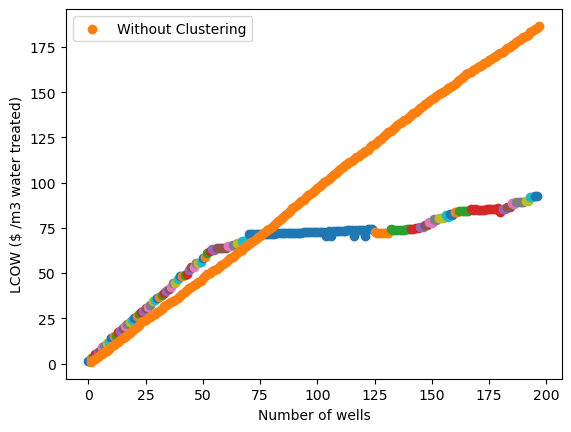

In [174]:
lcow = 0
fig,ax = plt.subplots()

for cluster in bw_cluster_lcow['cluster_id'].unique():
    temp = bw_cluster_lcow[bw_cluster_lcow['cluster_id']==cluster]
    lcow = lcow + temp.tail(1)['total_lcow'].values[0]

    ax.scatter(temp.index,lcow+temp['total_lcow'])

ax.scatter(bw_df_temp.index+1,bw_df_temp['lcow'].cumsum(),label='Without Clustering')

# ax.set_ylim([0,100])
ax.set_xlabel('Number of wells')
ax.set_ylabel('LCOW ($ /m3 water treated)')
ax.legend()

In [47]:
# case_study = 'big_spring'
# scenario = 'dwi_a'
# desired_recovery = 1
# ro_bounds = 'other' # or 'seawater'

# m = watertap_setup(case_study=case_study, scenario=scenario)
# m = get_case_study(m=m)

# # run the baseline watertap3 version of this treatment train
# m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds)

# m.fs.reverse_osmosis.membrane_area.unfix()
# m.fs.reverse_osmosis.feed.pressure.unfix()

# # Iterate over each cluster label

# bw_df_centroid_1 = bw_df_centroid[bw_df_centroid['state_alpha']=='TX']

# for centroid in bw_df_centroid_1['cluster_id'].unique():
#     bw_cluster = bw_df_centroid_1[bw_df_centroid["cluster_id"]==centroid]
    
#     # TDS 
#     avg_tds = 0
#     # well yield
#     avg_well_yield  = 0
#     # Iterate over each brackish water site within a cluster
#     for site in bw_cluster.unique_site_ID.unique():
#         # Calculate average well yield
#         avg_well_yield_old = avg_well_yield
#         avg_well_yield = avg_well_yield + bw_cluster[bw_cluster['unique_site_ID']==site]['well_yield'].values[0]

#         # Calculate average TDS
#         avg_tds = (avg_tds*avg_well_yield_old + bw_cluster[bw_cluster['unique_site_ID']==site]['TDS_kgm3'].values[0] * bw_cluster[bw_cluster['unique_site_ID']==site]['well_yield'].values[0])/avg_well_yield
        
